# Байесовские оценки. Задача 4


__Ильичёв А.С., 693__

In [1]:
import numpy as np
import scipy.stats as sts
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Здесь мы адаптируем задачу 5.1 к случаю, когда нам неизвестен параметр $\lambda$ и нужно получать для него байесовскую оценку. Не вдаваясь в подробности, напомним, что $E(N_t\rvert N_s) = N_s + \lambda(t-s)$ и повторим действия по считыванию данных из файла.

In [2]:
df = pd.read_csv('6.csv', names=['t'])
df.head(5)

,t
0,lambda = 105
1,t_0 = 500
2,t = 110000
3,198.4406
4,460.8092


В первых трех строчках файла лежат значения параметров. Сохраним их и уберем из датафрейма (мы уже знаем, что на самом деле нам дано $1/\lambda$). 

In [3]:
lam_true = 1/105
t0 = 500
t_fin = 110000
df = df.drop(df.index[[0,1,2]]).reset_index(drop=True).astype(float)
df.head()

,t
0,198.4406
1,460.8092
2,494.1672
3,517.8483
4,560.4000


#### 1. Возьмем в качестве априорного распределения $\lambda$ сопряженное к эскпоненциальному распределению и подберем его параметры.

На семинаре было показано, что сопряженным распределением к экспоненциальному является $\Gamma(\alpha, \beta)$, при этом байесовской оценкой будет $\lambda^* = \frac{n + \alpha}{\sum_1^nX_i + \beta}$.

При отстутствии информации оценкой будет $\lambda_0 = \frac\alpha\beta$. При этом мы знаем, что величина $1/\lambda_0$ (матожидание экспоненциального распределения) имеет смысл среднего промежутка времени между двумя соседними поломками серверов. Здравый смысл подсказывает, что это время много больше одной секунды, поэтому должно быть $\lambda_0 = \frac\alpha\beta \ll 1$ (будем считать $\frac\alpha\beta \le 0.1$). Построим несколько графиков плотности гамма-распределения с разными параметрами. Значения $\alpha > 1$ не рассматриваем, так как в этом случае, как следует из формулы для плотности гамма-распределения, в точке $x=0$ она будет равна нулю. То есть  образуется точка перегиба (нарисуем график для примера), и мы получим ненулевое наиболее вероятное значение $\lambda$, хотя на самом деле таких данных у нас нет.

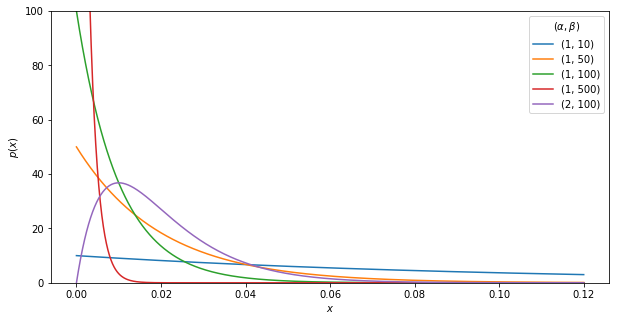

In [4]:
plt.figure(figsize=(10, 5))
g_pars = [(1, 10), (1, 50), (1, 100), (1, 500), (2, 100)]
x = np.linspace(0, 0.12, 1000)
for p in g_pars:
    plt.plot(x, sts.gamma(a=p[0], scale=1/p[1]).pdf(x), label=p)
    plt.legend(title=r'$(\alpha, \beta)$')
plt.ylim(0, 100)
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')
plt.show()

График сильно ограничен по обеим осям для наглядности (плотность гамма-распределения для наших параметров очень быстро убывает с ростом $x$). Видим, что для параметра (1, 10) плотность все еще велика для значений, больших 0.1, для параметров (1, 100) и (1, 500) плотность слишком резко падает, не доходя до 0.1, и только для (1, 50) получаем приемлемое распределение, примерно соответствующее $\lambda \in [0, 1]$.

In [5]:
p = (1, 50)

#### 2. Напишем программу для подсчета предсказаний.


За основу возьмем программу из задачи 5.1. Для наглядности будем выводить $1/\lambda$. Помним, что в датасете лежит кумулятивная сумма $df[n - 1] = \sum_{i=1}^nX_i$.

In [6]:
from time import sleep
def calc_pred(t0=t0, t_fin=t_fin, df=df, 
              sleep_time = t0 / 500, p=p, printing = True,
              calc_true = False):
    preds = []
    preds_true = []
    inv_lams = []
    t = 0
    t_last = df['t'].iloc[-1]
    while t <= t_last:
        df_curr = df[df['t'] <= t]
        N = len(df_curr)
        lam = (N + p[0]) / ((df_curr['t'].iloc[-1] 
                             if N > 0 else 0) + p[1])

        num = N + int((t_fin - t) *  lam) 
        if calc_true:
            num_true = N + int((t_fin - t) * lam_true) 
            preds_true.append(num_true)

        if printing:
            print('N_exp = {},\t 1/lam = {}'.format(num, 1 / lam))
        t += t0
        preds.append(num)
        inv_lams.append(1 / lam)
        sleep(sleep_time)
    if calc_true:
        return (preds, preds_true, inv_lams)
    else:
        return (preds, inv_lams)

In [7]:
calc_pred()

N_exp = 2200,	 1/lam = 50.0
N_exp = 807,	 1/lam = 136.0418
N_exp = 904,	 1/lam = 121.445875
N_exp = 1014,	 1/lam = 108.2975857142857
N_exp = 1029,	 1/lam = 106.74735263157895
N_exp = 1058,	 1/lam = 103.68314782608695
N_exp = 1010,	 1/lam = 108.66575555555555
N_exp = 1002,	 1/lam = 109.12150357142856
N_exp = 974,	 1/lam = 112.68439142857143
N_exp = 1016,	 1/lam = 108.17454523809525
N_exp = 1017,	 1/lam = 107.98793043478261
N_exp = 977,	 1/lam = 112.32102291666666
N_exp = 1057,	 1/lam = 103.9610344827586
N_exp = 1048,	 1/lam = 104.79874838709678
N_exp = 1033,	 1/lam = 106.27109230769231


KeyboardInterrupt: 

Не будем дожидаться конца работы программы и построим графики.

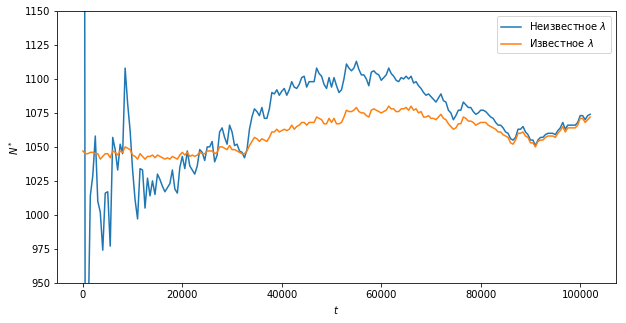

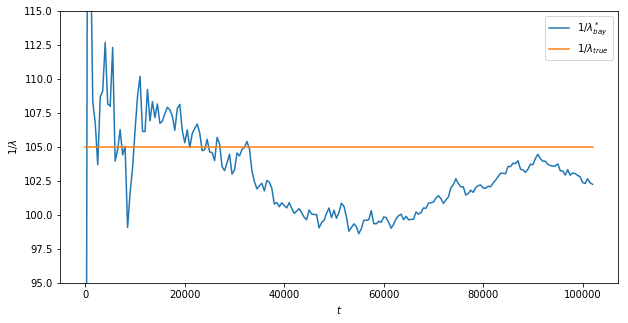

In [10]:
preds, preds_true, inv_lams = calc_pred(sleep_time=0, 
                        printing=False, calc_true=True)
ts = np.arange(0, df['t'].iloc[-1] + 1, t0)
plt.figure(figsize=(10, 5))
plt.plot(ts, preds, label=r'Неизвестное $\lambda$')
plt.plot(ts, preds_true, label=r'Известное $\lambda$')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$N^*$')
plt.ylim(950, 1150)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ts, inv_lams, label=r'$1/\lambda_{bay}^*$')
plt.plot([ts[0], ts[-1]], [1 / lam_true, 1 / lam_true],
         label=r'$1/\lambda_{true}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$1/\lambda$')
plt.legend()
plt.ylim(95, 115)
plt.show()

#### Вывод: 

Как видно, с помощью байесовских оценок и условного математического ожидания можно делать довольно точные предсказания даже при условии, что нам неизвестен параметр распределения. На большой выборке такое предсказание почти неотличимо от того, которое считает $\lambda$ известным (это следует из состоятельности байесовской оценки). Как и в задаче 5.1, предсказание учитывает состояние выборки. В нашем случае байесовская оценка немного завышает значения $\lambda$ (и занижает значения $1/\lambda$) относительно данного в таблице параметра. Скорее всего, эта проблема исправляется выбором более подходящих параметров априорного распределения, таких, чтобы пик плотности был около табличного значения $1/\lambda$, но мы считали это значение неизвестным при подборе параметров. 